In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple, defaultdict
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

## Wildstyle failures

In [2]:
ws = analyze.Analysis('results/wildstyle')
print(ws)

Analysis for Celeritas v0.3.2-rc.1 on wildstyle


In [3]:
ftab = analyze.make_failure_table(ws.failures())
ftab.to_frame()

,Failure


Unconverged tracks (from runs that didn't fail):

In [4]:
summed = analyze.summarize_instances(ws.result[['unconverged']])
unconv = summed[('unconverged', 'mean')]
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


# Results
## Summit

In [5]:
summit = analyze.Analysis('results/summit')
print(summit)
summed = summit.summed
problems = summit.problems()
problem_to_abbr = summit.problem_to_abbr(problems)
p_to_i = dict(zip(problems, itertools.count()))

Analysis for Celeritas v0.4.0-dev.99+4507705b5 on summit


### Failures

Average number of unconverged tracks:

In [6]:
unconv = analyze.summarize_instances(summit.result['unconverged'])['mean']
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


### Timing tables

In [7]:
(fig, [run_ax, setup_ax]) = plt.subplots(nrows=2,
                                         gridspec_kw=dict(height_ratios=[3, 1]),
                                         subplot_kw=dict(yscale='log'))
summit.plot_results(run_ax, summed['total_time'])
run_ax.legend();
run_ax.set_ylabel('Run [s]')
run_ax.tick_params(labelbottom=False)
summit.plot_results(setup_ax, summed['setup_time'])
setup_ax.set_ylabel('Setup [s]')
analyze.annotate_metadata(run_ax, summit)
plt.tight_layout()
fig.savefig('plots/timing.pdf', transparent=True)
plt.close()

In [8]:
times = summed[('total_time', 'mean')].unstack()
times.style.format(analyze.float_fmt_transform(2))

In [9]:
#testem3 = event_rate['mean'].xs('testem3-flat+field+msc', level='problem').unstack('arch')

In [10]:
#testem3 / testem3.loc[('vecgeom', 'cpu')]

In [11]:
speedup = analyze.get_cpugpu_ratio(summed['total_time'])
speedup.dropna().style.format(analyze.float_fmt_transform(1))

In [12]:
speedup['mean'].unstack('geo').describe()

geo,orange,vecgeom
count,10.000000,6.000000
mean,36.985957,23.921153
std,4.744654,15.110593
min,27.339709,6.735867
25%,34.705025,11.428507
50%,38.643319,23.375858
75%,40.190804,35.500869
max,42.658406,43.050738


In [13]:
#df = speedup.apply(np.vectorize(analyze.float_fmt_transform(1)))
speedup_out = np.full((len(speedup), 3), "", dtype=object)
_abbrev = summit.problem_to_abbr()
prev_prob = None
for (i, ((prob, geo), row)) in enumerate(speedup.iterrows()):
    if prob != prev_prob:
        abbr = _abbrev[prob]
        speedup_out[i, 0] = f"{prob} [{abbr}]"
    speedup_out[i, 1] = geo
    speedup_out[i, 2] = "{:.1f}× (±{:.1f})".format(*row)
    prev_prob = prob
    
with open("results/summit/speedup.md", "w") as f:
    analyze.dump_markdown(f,
                  ["Problem", "Geometry", "Speedup"], 
                  speedup_out,
                  alignment="<<>")

In [14]:
_desc = (speedup['mean'].dropna() * 7).describe()
print("CPU:GPU equivalence: {min:.0f}× to {max:.0f}×".format(**_desc))

CPU:GPU equivalence: 47× to 301×


In [15]:
# Determine the fraction of action time spent in geometry routines
action_times_inst = analyze.unstack_subdict(summit.result['action_times'][summit.valid]).T
total_time_inst = summit.result['total_time']
geo_actions = [lab for lab in action_times_inst.index
               if lab.startswith('along-step-') or lab.startswith('geo-')]
geo_frac_inst = action_times_inst.loc[geo_actions].sum() / total_time_inst
geo_frac = analyze.summarize_instances(geo_frac_inst)

In [16]:
geo_frac['mean'].unstack('arch')[['cpu', 'gpu+sync']]

arch                                 cpu  gpu+sync
problem                geo                        
cms2018                vecgeom  0.450662       NaN
cms2018+field+msc      vecgeom  0.686853  0.916186
simple-cms+field       orange   0.356834       NaN
simple-cms+field+msc   orange   0.493804       NaN
                       vecgeom  0.481805       NaN
simple-cms+msc         orange   0.405947       NaN
testem15               orange   0.178531       NaN
testem15+field         orange   0.330306  0.306681
                       vecgeom       NaN  0.257174
testem15+field+msc     orange   0.460847       NaN
                       vecgeom  0.440202       NaN
testem3-flat           orange   0.260258       NaN
                       vecgeom  0.290735       NaN
testem3-flat+field     orange   0.397781       NaN
testem3-flat+field+msc orange   0.601491  0.665620
                       vecgeom  0.647211  0.848719
testem3-flat+msc       orange   0.532898       NaN

### Plots

In [17]:
fig, ax = plt.subplots()
summit.plot_results(ax, speedup)
ax.set_ylabel("Speedup (7-CPU / 1-GPU wall time)")
ax.set_ylim([0, None])
analyze.annotate_metadata(ax, summit)
plt.tight_layout()
fig.savefig('plots/speedups.pdf', transparent=True)
#fig.savefig('results/summit/speedup.png', transparent=False, dpi=150)
plt.close()

In [18]:
fig, axes = plt.subplots(nrows=2, figsize=(4,4), subplot_kw=dict(yscale='log'))
for (ax, q) in zip(axes, ['step', 'primary']):
    summit.plot_results(ax, analyze.inverse_summary(summed['avg_time_per_' + q]))
    ax.set_ylabel(q + ' per sec')
    if ax != axes[-1]:
        ax.tick_params(labelbottom=False)
    ax.legend()
plt.tight_layout()
fig.savefig('plots/steps-vs-primaries.pdf')
plt.close()

In [19]:
(fig, (time_ax, geo_ax)) = plt.subplots(
    nrows=2, #figsize=(4, 4),
    gridspec_kw=dict(height_ratios=[3, 1])
)
analyze.plot_event_rate(time_ax, summit)
time_ax.tick_params(labelbottom=False)
time_ax.legend()
summit.plot_results(geo_ax, geo_frac * 100)
geo_ax.set_ylabel("Geometry [%]")
geo_ax.set_ylim([0, 100])
plt.tight_layout()
fig.savefig('plots/throughput-geo.pdf', transparent=True)
plt.close()

### Action fraction pie charts

In [20]:
avg_time = summed[('total_time', 'mean')].T
mean_action_times = summit.action_times().xs('mean', axis=1, level=1).T

In [21]:
for (prob, geo) in itertools.product(
        ["testem15+field", "testem3-flat+field+msc", "cms2018+field+msc"],
        ["vecgeom", "orange"]):
    try:
        plot_times = mean_action_times.xs((prob, geo), axis=1, level=('problem', 'geo')).dropna(axis=1, how='all')
    except KeyError:
        plot_times = pd.DataFrame()
    if plot_times.empty:
        print("Missing problem/geo:", prob, geo)
        continue
    md = {k: getattr(summit, k) for k in ["version", "system"]}
    pieplot = analyze.PiePlotter(plot_times)
    
    # Loop over CPU/GPU
    for arch in pieplot.times:
        (fig, ax) = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"),
                                 layout="constrained")
        pieplot(ax, arch)
        name = (prob, geo, arch)
        slashname = "/".join(name)
        fig.text(
            0.98, 0.1, f"{slashname}\n{md['version']} on {md['system']}",
            va='bottom', ha='right',
            fontstyle='italic', color=(0.75,)*4, size='xx-small',
#            zorder=-100
        )

        dashname = "-".join(name)        
        fig.savefig(f'plots/actions-{dashname}.pdf', transparent=True)
        plt.close()

Missing problem/geo: cms2018+field+msc orange


### Plot per-step timing on GPU

In [22]:
for p in ['cms2018', 'cms2018+field+msc']:
    data = summit.load_results((p, 'vecgeom', 'gpu'), 0)
    (fig, axes) = plt.subplots(nrows=2, figsize=(3, 4), sharex=True)
    for i, ax, plot in zip(itertools.count(),
                           axes,
                           [analyze.plot_counts, analyze.plot_accum_time_inv]):
        objs = plot(ax, data)
        analyze.annotate_metadata(ax, data['_metadata'])
        if i == 0:
            ax.set_xlabel(None)
    fig.savefig(f'plots/per-step-{p}.pdf', transparent=True)
    plt.tight_layout()
    plt.close()
    
    (fig, ax) = plt.subplots(figsize=(4, 3))
    analyze.plot_time_per_step(ax, data, scale=2)
    analyze.annotate_metadata(ax, summit)
    plt.tight_layout()
    fig.savefig(f'plots/time-per-step-{p}.pdf', transparent=True)
    plt.close()

## Crusher

In [23]:
def get_step_times(results):
    new_idx = []
    times = []
    for i in results.index:
        try:
            outp = results.load_results(i, 0)
            step_times = analyze.StepTimeGetter(outp, stream=0)()
        except Exception:
            continue
        times.append([step_times[i] for i in range(2)])
        new_idx.append(i)
    return pd.DataFrame(times, index=pd.MultiIndex.from_tuples(new_idx))

In [24]:
crusher = analyze.Analysis('results/crusher')
print(crusher)

Analysis for Celeritas v0.4.0-dev.99+4507705b5 on crusher


In [25]:
csum = crusher.summed

In [26]:
csum[('total_time', 'mean')].unstack()

,arch,cpu,gpu,gpu+sync
problem,geo,,,
simple-cms+field,orange,103.362734,2.822081,NaN
simple-cms+field+msc,orange,94.557441,3.178746,NaN
simple-cms+msc,orange,112.772403,2.551724,NaN
testem15,orange,83.936064,1.928067,NaN
testem15+field,orange,78.310988,2.001378,2.055908
testem15+field+msc,orange,97.807941,2.273290,NaN
testem3-flat,orange,111.720558,4.255798,NaN
testem3-flat+field,orange,103.206358,5.990480,NaN
testem3-flat+field+msc,orange,143.934147,9.232918,9.355201


In [27]:
step_times = get_step_times(crusher)
step_times

,,,0,1
testem15,orange,gpu,0.000718,0.000735
testem15+field,orange,gpu,0.000744,0.000766
testem15+field+msc,orange,gpu,0.000784,0.000915
simple-cms+msc,orange,gpu,0.000723,0.000558
simple-cms+field,orange,gpu,0.001064,0.000844
simple-cms+field+msc,orange,gpu,0.001001,0.000871
testem3-flat,orange,gpu,0.000692,0.000507
testem3-flat+field,orange,gpu,0.001014,0.000550
testem3-flat+msc,orange,gpu,0.000732,0.000537
testem3-flat+field+msc,orange,gpu,0.001070,0.000600


In [28]:
step_times[0] / step_times[1]

testem15                orange  gpu         0.977435
testem15+field          orange  gpu         0.970710
testem15+field+msc      orange  gpu         0.856067
simple-cms+msc          orange  gpu         1.294923
simple-cms+field        orange  gpu         1.260745
simple-cms+field+msc    orange  gpu         1.149400
testem3-flat            orange  gpu         1.367091
testem3-flat+field      orange  gpu         1.842589
testem3-flat+msc        orange  gpu         1.361376
testem3-flat+field+msc  orange  gpu         1.781760
testem15+field          orange  gpu+sync    1.033474
testem3-flat+field+msc  orange  gpu+sync    1.517926
dtype: float64

In [29]:
analyze.get_cpugpu_ratio(csum['total_time'])

,,mean,std
problem,geo,,
simple-cms+field,orange,36.626430,5.737030
simple-cms+field+msc,orange,29.746778,5.920959
simple-cms+msc,orange,44.194598,10.373099
testem15,orange,43.533782,11.250236
testem15+field,orange,39.128531,17.505092
testem15+field+msc,orange,43.024845,17.441633
testem3-flat,orange,26.251376,10.255261
testem3-flat+field,orange,17.228397,3.799089
testem3-flat+field+msc,orange,15.589236,3.808210


## Frontier

In [30]:
print("\n".join(k for (k, v) in ftab.items()
                if 'is_soft' in v))

In [31]:
frontier = analyze.Analysis('results/frontier')
print(frontier)

Analysis for Celeritas v0.4.0-dev.99+4507705b5 on frontier


In [32]:
step_times = get_step_times(frontier)
step_times

,,,0,1
testem15,orange,gpu,0.000713,0.000737
testem15+field,orange,gpu,0.000741,0.000776
testem15+field+msc,orange,gpu,0.000775,0.000907
simple-cms+msc,orange,gpu,0.000740,0.000549
simple-cms+field,orange,gpu,0.000968,0.000837
simple-cms+field+msc,orange,gpu,0.001093,0.000868
testem3-flat,orange,gpu,0.000685,0.000496
testem3-flat+field,orange,gpu,0.001026,0.000547
testem3-flat+msc,orange,gpu,0.000720,0.000531
testem3-flat+field+msc,orange,gpu,0.000951,0.000589


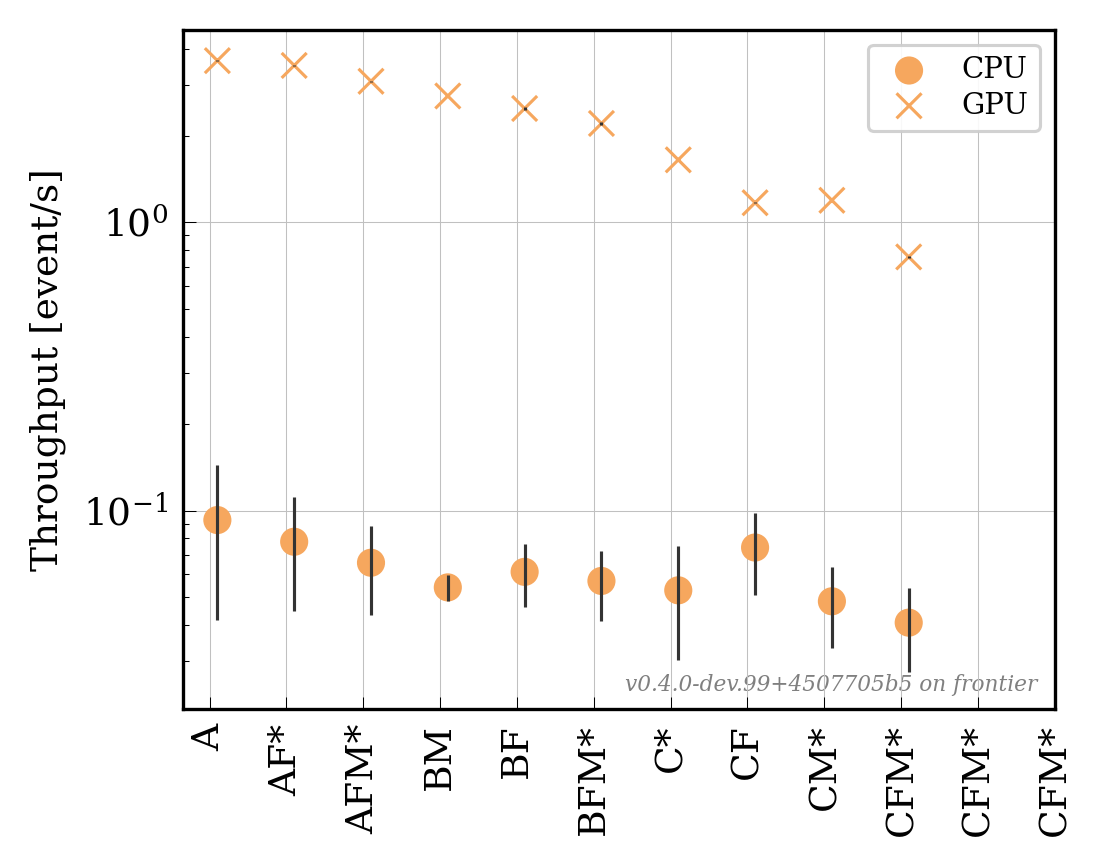

In [33]:
(fig, ax) = plt.subplots()
analyze.plot_event_rate(ax, frontier)
ax.legend()

In [34]:
frontier_rates = analyze.calc_event_rate(frontier)
summit_rates = analyze.calc_event_rate(summit, summit.summed.loc[frontier_rates.index])

counts = {
    ('summit', 'cpu'): 7,
    ('summit', 'gpu'): 1,
    ('frontier', 'cpu'): 8,
    ('frontier', 'gpu'): 1,
}

In [35]:
(frontier_rates['mean'] / summit_rates['mean']).unstack()

,arch,cpu,gpu,gpu+sync
problem,geo,,,
simple-cms+field,orange,0.707115,0.813708,NaN
simple-cms+field+msc,orange,0.852653,0.862438,NaN
simple-cms+msc,orange,0.696297,0.861898,NaN
testem15,orange,0.799566,0.803897,NaN
testem15+field,orange,0.822645,0.916965,0.915654
testem15+field+msc,orange,0.866021,0.950706,NaN
testem3-flat,orange,0.815803,0.736187,NaN
testem3-flat+field,orange,1.393587,0.800926,NaN
testem3-flat+field+msc,orange,1.313106,0.768538,0.778970


In [36]:
fig, ax = plt.subplots()
ax.set_yscale('log')
for offset, color, machine, rates in [(-0.05, '#7A954F', 'Summit', summit_rates),
                                      (0.05, '#BC5544', 'Frontier', frontier_rates)]:
    for arch in ['cpu', 'gpu']:
        summary = rates.xs(arch, level='arch')
        index = np.array([p_to_i[p]
                          for p in summary.index.get_level_values('problem')], dtype=float)
        index += offset
    
        mark = analyze.ARCH_SHAPES[arch]
        count = counts[(machine.lower(), arch)]
        arch = arch.upper()
        ax.errorbar(index, summary['mean'], summary['std'],
                    capsize=0, fmt='none', ecolor=(0.2,)*3)
        scat = ax.scatter(index, summary['mean'], c=color, marker=mark,
                         label=f"{machine} ({count} {arch})")    
xax = ax.get_xaxis()
xax.set_ticks(np.arange(len(problems)))
xax.set_ticklabels(list(problem_to_abbr.values()), rotation=90)
grid = ax.grid()
ax.set_axisbelow(True)
ax.legend()
ax.set_ylabel(r"Event rate [1/s]")
analyze.annotate_metadata(ax, summit)
plt.tight_layout()
fig.savefig('plots/frontier-vs-summit.pdf')
plt.close()

# Occupancy

In [37]:
BYTES_PER_REG = 4 # 32-bit registers

def load_kernels(results, problem, geo):
    return results.load_results((problem, geo, 'gpu'), 0)['system']['kernels']

def kernel_stats_dataframe(kernel_stats):
    values = []
    index = []
    for (instance, kernels) in kernel_stats.items():
        arch, _, geo = instance.partition('/')
        for (ki, stats) in enumerate(kernels):
            stats.pop('stack_size', None) # Unavailable with HIP
            row = list(stats.values())
            row.append(ki)
            values.append(row)
            name = stats['name']
            if name == "extend-from-secondaries":
                # Fixup duplicate name
                name = f"{name}-{ki}"
            index.append((arch, geo, name))
    index=pd.MultiIndex.from_tuples(index, names=('arch', 'geo', 'name'))
    columns = pd.Index(list(stats.keys()) + ['kernel_index'])
    result = pd.DataFrame(values, index=index, columns=columns)
    del result['name']
    del result['print_buffer_size']
    result['register_mem'] = result['num_regs'] * BYTES_PER_REG
    return result

In [38]:
def plot_kernel_mem(ax, ksdf, colors, labels):
    labels = ['local_mem', 'register_mem']
    y = np.arange(len(labels))
    width = .9 / len(multimem)
    ynudge = np.linspace(-0.34, 0.34, len(multimem))
    
    for (i, (k, mem)) in enumerate(multimem.items()):
        values = np.array(list(mem.values()), dtype=dtype)

        ax.barh(y + ynudge[i], values['register'], width,
                color=colors[k], label=f'{pretty_labels[k]}')
        ax.barh(y + ynudge[i], values['local'], width, left=values['register'],
                color=colors[k + '.spill'])#, label=f'Local spill ({pretty_labels[k]})')

    ax.invert_yaxis();
    ax.set_xlabel('Memory [B]')
    ax.set_yticks(y, labels)
    leg = ax.legend()
    leg.set_title("Register usage (light)\nLocal spill (dark)")
    leg.get_title().set_fontsize('x-small')

In [39]:
kernel_stats = {
    'cuda/vecgeom': load_kernels(summit, 'testem3-flat+field+msc', 'vecgeom'),
    'cuda/orange': load_kernels(summit, 'testem3-flat+field+msc', 'orange'),
    'hip/orange': load_kernels(frontier, 'testem3-flat+field+msc', 'orange'),
}
pretty_labels = {
    'cuda/vecgeom': 'NVIDIA V100 (VecGeom)',
    'cuda/orange': 'NVIDIA V100 (ORANGE)',
    'hip/orange': 'AMD MI250 (ORANGE)',
}
colors = {
    'cuda/vecgeom': (191, 40, 96),
    'cuda/vecgeom.spill': (107, 76, 88),
    'cuda/orange': (153, 168, 50),
    'cuda/orange.spill': (106, 112, 67),
    'hip/orange': (57, 140, 173),
    'hip/orange.spill': (78, 101, 110),
}
colors = {k: np.array(v, dtype=float) / 255 for k, v in colors.items()}

In [40]:
ksdf = kernel_stats_dataframe(kernel_stats)

In [41]:
with open("kernel-occupancy.md", "w") as f:
    analyze.dump_markdown(
        f,
        list(ksdf.index.names) + ['local', 'register', 'occupancy'],
        np.concatenate([
            np.array([list(v) for v in ksdf.index]).T,
            [
                ksdf['local_mem'].apply("{:d}".format),
                ksdf['register_mem'].apply("{:d}".format),
                ksdf['occupancy'].apply("{:.03f}".format)
            ],
        ], axis=0).T,
        alignment="<<<>>>"
    )

In [42]:
labels = {
    'cuda/vecgeom': 'NVIDIA V100 (VecGeom)',
    'cuda/orange': 'NVIDIA V100 (ORANGE)',
    'hip/orange': 'AMD MI250 (ORANGE)',
}
markers = {
    'cuda/vecgeom': '.',
    'cuda/orange': '+',
    'hip/orange': 'x',
}

(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    s = ax.scatter(ks['register_mem'], ks['local_mem'],
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
ax.set_xlabel('Register usage [B]')
ax.set_ylabel('Memory spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
#fig.savefig('plots/reg-vs-spill.png')
fig.savefig('plots/reg-vs-spill.pdf', transparent=True)
plt.close()

In [43]:
(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    tot_mem = ks['register_mem'] + ks['local_mem']
    s = ax.scatter(ks['occupancy'], tot_mem,
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
#ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Register + spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
#fig.savefig('plots/occupancy-vs-mem.png')
fig.savefig('plots/occupancy-vs-mem.pdf', transparent=True)
plt.close()

In [44]:
(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    s = ax.scatter(ks['occupancy'], ks['local_mem'],
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
#ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Local memory spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
#fig.savefig('plots/occupancy-vs-spill.png')
fig.savefig('plots/occupancy-vs-spill.pdf', transparent=True)
plt.close()

In [45]:
ksdf[ksdf['local_mem'] > 64]

const_mem    heap_size  \
arch geo     name                                                       
cuda vecgeom scat-rayleigh                         20776      8388608   
     orange  initialize-tracks                         0      8388608   
             along-step-uniform-msc-propagate          0      8388608   
             photoel-livermore                         0      8388608   
             scat-rayleigh                             0      8388608   
             geo-boundary                              0      8388608   
hip  orange  initialize-tracks                         0  68702699520   
             geo-boundary                              0  68702699520   

                                               local_mem  max_blocks_per_cu  \
arch geo     name                                                             
cuda vecgeom scat-rayleigh                           104                  4   
     orange  initialize-tracks                       112                  4   
             along-step-uniform-msc-propagate        240                  2   
             photoel-livermore                        80                  3   
             scat-rayleigh                           104                  4   
             geo-boundary                            176                  4   
hip  orange  initialize-tracks                       120                  5   
             geo-boundary                            304                  5   

                                               max_threads_per_block  \
arch geo     name                                                      
cuda vecgeom scat-rayleigh                                       256   
     orange  initialize-tracks                                   256   
             along-step-uniform-msc-propagate                    256   
             photoel-livermore                                   256   
             scat-rayleigh                                       256   
             geo-boundary                                        256   
hip  orange  initialize-tracks                                   256   
             geo-boundary                                        256   

                                               max_warps_per_eu  num_regs  \
arch geo     name                                                           
cuda vecgeom scat-rayleigh                                   32        64   
     orange  initialize-tracks                               32        64   
             along-step-uniform-msc-propagate                16       128   
             photoel-livermore                               24        68   
             scat-rayleigh                                   32        63   
             geo-boundary                                    32        64   
hip  orange  initialize-tracks                                5        90   
             geo-boundary                                     5        92   

                                               occupancy  threads_per_block  \
arch geo     name                                                             
cuda vecgeom scat-rayleigh                         0.500                256   
     orange  initialize-tracks                     0.500                256   
             along-step-uniform-msc-propagate      0.250                256   
             photoel-livermore                     0.375                256   
             scat-rayleigh                         0.500                256   
             geo-boundary                          0.500                256   
hip  orange  initialize-tracks                     0.625                256   
             geo-boundary                          0.625                256   

                                               kernel_index  register_mem  
arch geo     name                                                          
cuda vecgeom scat-rayleigh                               17           256  
     orange  i